In [1]:
from math import *
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import matplotlib.pyplot as plt
from skimage.transform import rescale

import sys
sys.path.append("/Users/henrybest/PythonStuff/Code/")
import Amoeba
import QuasarModelFunctions as QMF  #if QMF is saved elsewhere, append that path too
plt.style.use("plot_style_large_font.txt")

In [2]:
M = 1e8 * const.M_sun.to(u.kg)
M_dot = 1.0 * const.M_sun.to(u.kg)/u.year.to(u.s) / u.s
G = const.G
c = const.c
pi = np.pi
sigma = const.sigma_sb
h = const.h
k = const.k_B
M_Proton = const.m_p
Thompson_Cross_Section = const.sigma_T


rg = QMF.CalcRg(M)

r_min1 = (12) * rg * u.m
r_min2 = (6) * rg * u.m

numgrs = 2000
r_max = numgrs * rg * u.m

diskres = 1000  #Corresponds to how many radial slices I add
incang = ((0)) * np.pi/180
incang2 = 60*np.pi/180

disk1 = np.zeros([(2*diskres), (2*diskres)])
disk2 = np.zeros([(2*diskres), (2*diskres)])
disk3 = np.zeros(np.shape(disk2))
rad1 = np.zeros(np.shape(disk1))
rad2 = np.zeros(np.shape(disk2))

xvals = np.linspace(-r_max.value, r_max.value, 2*diskres) 
yvals1 = xvals.copy()
yvals2 = xvals.copy() / np.cos(incang2)

X1, Y1 = np.meshgrid(yvals1, xvals)
R1 = (X1**2 + Y1**2)**0.5 #+ 0.5 * r_max.value / diskres

X2, Y2 = np.meshgrid(yvals2, xvals)
R2 = (X2**2 + Y2**2)**0.5 #+ 0.5 * r_max.value / diskres

mask1in = R1 > r_min1.value
mask1out = R1 < r_max.value
mask1 = np.logical_and(mask1in, mask1out)
mask2 = np.logical_and((R1 > r_min2.value), (R1 < r_max.value))
mask3 = np.logical_and((R2 > r_min2.value), (R2 < r_max.value))

disk1 = np.nan_to_num(QMF.AccDiskTemp(R1*mask1, r_min1.value, M, M_dot, eddingtons=0.15))
disk2 = np.nan_to_num(QMF.AccDiskTemp(R1*mask2, r_min2.value, M, M_dot, eddingtons=0.15))
disk3 = np.nan_to_num(QMF.AccDiskTemp(R2*mask3, r_min2.value, M, M_dot, eddingtons=0.15))


ADisk1 = Amoeba.ThinDisk(8.0, 0.0, numgrs, 0, 6, disk1.T, np.zeros(np.shape(disk1.T)), np.ones(np.shape(disk1.T)), R1)
ADisk2 = Amoeba.ThinDisk(8.0, 0.0, numgrs, 0, 12, disk2.T, np.zeros(np.shape(disk2.T)), np.ones(np.shape(disk2.T)), R1)
ADisk3 = Amoeba.ThinDisk(8.0, 0.0, numgrs, 60, 12, disk3.T, np.zeros(np.shape(disk3.T)), np.ones(np.shape(disk3.T)), R2)

DerivDisk1 = ADisk1.MakeDBDTMap(400)
DerivDisk2 = ADisk2.MakeDBDTMap(400)
DerivDisk3 = ADisk3.MakeDBDTMap(400)

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:166: RuntimeWarning: divide by zero encountered in true_divide
  tempmap = ( ( (3.0 * G * M * m0_dot * (1.0 - ((r_in) / r)**(0.5))) / (8.0 * pi * sigma * Rs**3) )**(0.25)).decompose().value * (r**(-(3-beta)/4))
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:166: RuntimeWarning: divide by zero encountered in power
  tempmap = ( ( (3.0 * G * M * m0_dot * (1.0 - ((r_in) / r)**(0.5))) / (8.0 * pi * sigma * Rs**3) )**(0.25)).decompose().value * (r**(-(3-beta)/4))
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:172: RuntimeWarning: invalid value encountered in multiply
  temp = (visc_temp**4 + geometric_term * Lx)**(1/4) * zeroes
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength

In [3]:
TF1 = ADisk1.ConstructDiskTransferFunction(400, smooth=False)
TF2 = ADisk2.ConstructDiskTransferFunction(400, smooth=False)
TF3 = ADisk3.ConstructDiskTransferFunction(400, smooth=False)

TF1s = np.sum(np.linspace(0, np.size(TF1)-1, np.size(TF1)) * (TF1))
TF2s = np.sum(np.linspace(0, np.size(TF2)-1, np.size(TF2)) * (TF2))
TF3s = np.sum(np.linspace(0, np.size(TF3)-1, np.size(TF3)) * (TF3))

TF1c = TF1s/np.sum(TF1)
TF2c = TF2s/np.sum(TF2)
TF3c = TF3s/np.sum(TF3)

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:522: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*T_orig**3)


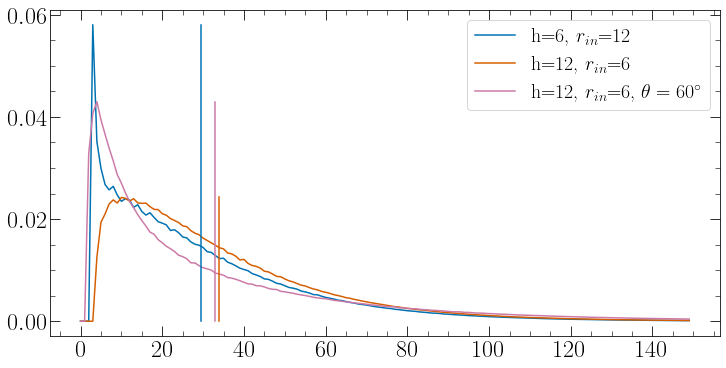

In [4]:
lim=150

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(TF1[:lim], label=r'h=6, $r_{in}$=12')
ax.plot(TF2[:lim], label=r'h=12, $r_{in}$=6')
ax.plot(TF3[:lim], label=r'h=12, $r_{in}$=6, $\theta=60^{\circ}$')
ax.plot([TF1c, TF1c], [0, np.max(TF1)], c='#0072B2')
ax.plot([TF2c, TF2c], [0, np.max(TF2)], c='#D55E00')
ax.plot([TF3c, TF3c], [0, np.max(TF3)], c='#CC79A7')
ax.legend()
plt.show()

In [5]:
t1, logTF1 = QMF.ConstructDiskTransferFunction(DerivDisk1, disk1, 0, M, 0, ADisk1.c_height, smooth=False, spacing='log', numGRs=2000, units='hours')
t2, logTF2 = QMF.ConstructDiskTransferFunction(DerivDisk2, disk2, 0, M, 0, ADisk2.c_height, smooth=False, spacing='log', numGRs=2000)
t3, logTF3 = QMF.ConstructDiskTransferFunction(DerivDisk3, disk3, 60, M, 0, ADisk3.c_height, smooth=False, spacing='log', numGRs=2000)

linTF1 = QMF.ConstructDiskTransferFunction(DerivDisk1, disk1, 0, M, 0, ADisk1.c_height, smooth=False, numGRs=2000)
linTF2 = QMF.ConstructDiskTransferFunction(DerivDisk2, disk2, 0, M, 0, ADisk2.c_height, smooth=False, numGRs=2000)
linTF3 = QMF.ConstructDiskTransferFunction(DerivDisk3, disk3, 60, M, 0, ADisk3.c_height, smooth=False, numGRs=2000)



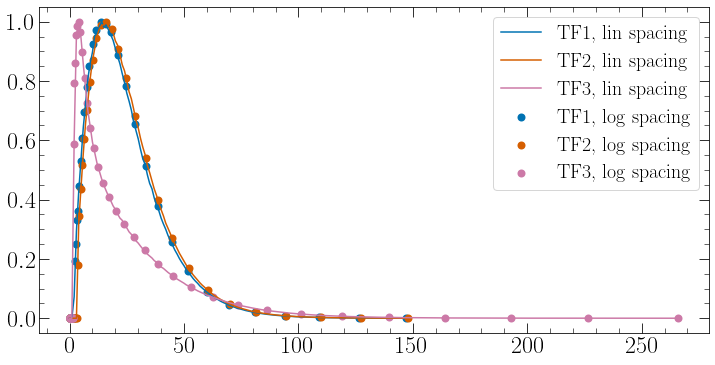

In [6]:
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.scatter(t1, np.nan_to_num(logTF1)/np.max(np.nan_to_num(logTF1)), linewidth=2, label='TF1, log spacing')
ax1.scatter(t2, np.nan_to_num(logTF2)/np.max(np.nan_to_num(logTF2)), linewidth=2, label='TF2, log spacing')
ax1.scatter(t3, np.nan_to_num(logTF3)/np.max(np.nan_to_num(logTF3)), linewidth=2, label='TF3, log spacing')
ax1.plot(linTF1/np.max(linTF1), label='TF1, lin spacing')
ax1.plot(linTF2/np.max(linTF2), label='TF2, lin spacing')
ax1.plot(linTF3/np.max(linTF3), label='TF3, lin spacing')
ax1.legend()
#ax1.set_xlim(0, 20)

# Log space in transfer functions works. Microlensing work below.

In [7]:
path_to_lensmap = '/Users/henrybest/PythonStuff/LensingMaps/SampleMagMaps/map_1/map.fits'


In [8]:
Map1 = Amoeba.MagnificationMap(2.0, 1.0, path_to_lensmap, 0.3, 0.39)

In [9]:
print('shape of map :',np.shape(Map1.mag_map))
print('ratio between rays and magnification :', Map1.ray_to_mag_ratio)
print('max mag:', np.max(Map1.mag_map), 'min mag:', np.min(Map1.mag_map))
print('pixel size on map:', Map1.px_size)

shape of map : (10000, 10000)
ratio between rays and magnification : 0.005845732409492475
max mag: 207.4884261425259 min mag: 0.7540994808245293
pixel size on map: 863305686197.3383


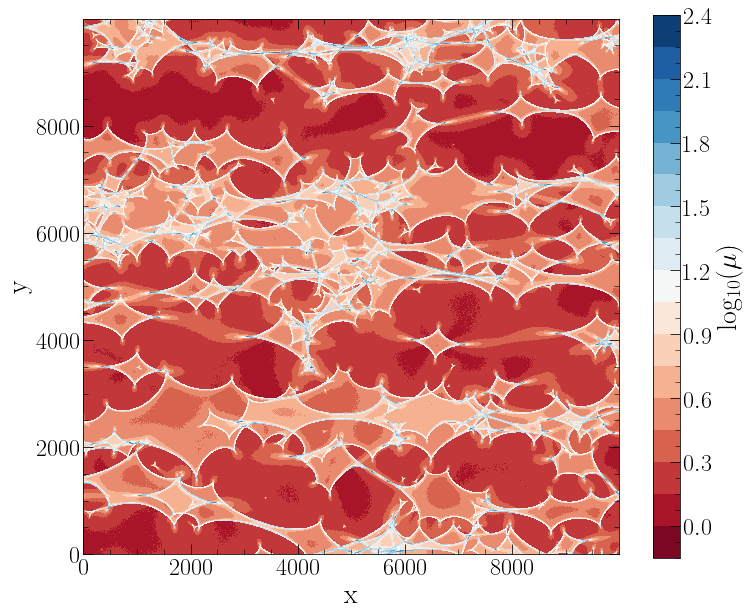

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
conts = ax.contourf(np.log10(Map1.mag_map), 20, cmap='RdBu')
ax.set_aspect(1)
cbar = plt.colorbar(conts, label=r'log$_{10}(\mu)$')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [11]:
brightnessmap400 = ADisk1.MakeSurfaceIntensityMap(400)

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


<ipython-input-12-72e0ee02d9c9>:2: RuntimeWarning: divide by zero encountered in log10
  conts = ax.contourf(np.log10(brightnessmap400), 20)
<ipython-input-12-72e0ee02d9c9>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(conts, cmap='plasma')


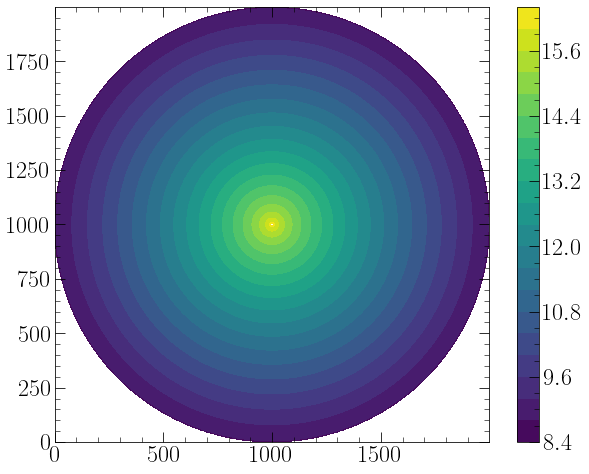

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
conts = ax.contourf(np.log10(brightnessmap400), 20)
ax.set_aspect(1)
cbar = plt.colorbar(conts, cmap='plasma')
plt.show()

In [13]:
print('shape of disk :', np.shape(brightnessmap400))
print('pixel size on disk map :', ADisk1.pxsize)
print('ratio of disk_px_size / map_px_size :', ADisk1.pxsize/Map1.px_size)

shape of disk : (2000, 2000)
pixel size on disk map : 295325007610.02496
ratio of disk_px_size / map_px_size : 0.3420862532608389


In [14]:
convo400, pix_size400, pix_shift400 = Map1.Convolve(ADisk1, 400)

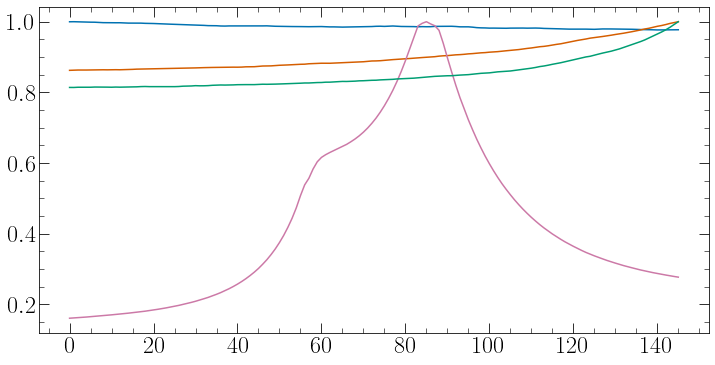

In [15]:
np.random.seed(772)
lc1 = QMF.PullLC(convo400.real, Map1.px_size, 400, 10, pix_shift400)
lc2 = QMF.PullLC(convo400.real, Map1.px_size, 400, 10, pix_shift400)
lc3 = QMF.PullLC(convo400.real, Map1.px_size, 400, 10, pix_shift400)
lc4 = QMF.PullLC(convo400.real, Map1.px_size, 400, 10, pix_shift400)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(lc1/np.max(lc1))
plt.plot(lc2/np.max(lc2))
plt.plot(lc3/np.max(lc3))
plt.plot(lc4/np.max(lc4))
plt.show()

# Microlensing is working fine

In [16]:
def MicrolensedResponse(MagMap, AccDisk, wavelength, coronaheight, rotation=False, x_position=None, y_position=None,
                        axisoffset=0, angleoffset=0, unit='hours', smooth=False, returnmaps=False):
    '''
    This function aims to microlens the response from a fluctuation in the lamppost geometry at some position 
    on the magnification map
    '''
    from skimage.transform import rescale
    from numpy.random import rand
    from scipy.signal import savgol_filter
    reprocessedmap = AccDisk.MakeDBDTMap(wavelength)
    pxratio = AccDisk.pxsize/MagMap.px_size
    adjusteddisk = rescale(reprocessedmap*AccDisk.MakeDTDLxMap(wavelength, axisoffset=axisoffset,
                                                           angleoffset=angleoffset), pxratio)
    adjustedtimedelays = rescale(AccDisk.MakeTimeDelayMap(axisoffset=axisoffset, 
                                                            angleoffset=angleoffset, unit=unit), pxratio)
    edgesize = np.size(adjusteddisk, 0) # This is the edge length we must avoid
    
    if x_position: 
        if x_position - edgesize > 0 and x_position + edgesize//2 < MagMap.resolution:
            xposition = x_position
        else: 
            xposition = int(edgesize + rand() * (MagMap.resolution - 2*edgesize))
    else: 
        xposition = int(edgesize + rand() * (MagMap.resolution - 2*edgesize))

    if y_position: 
        if y_position - edgesize > 0 and y_position + edgesize//2 < MagMap.resolution:
            yposition = y_position
        else: 
            yposition = int(edgesize + rand() * (MagMap.resolution - 2*edgesize))
    else: 
        yposition = int(edgesize + rand() * (MagMap.resolution - 2*edgesize))
        
    xposition -= edgesize//2
    yposition -= edgesize//2
    
    magnifiedresponse = np.nan_to_num(adjusteddisk * MagMap.mag_map[yposition:yposition+edgesize, xposition:xposition+edgesize])
    
    if returnmaps==True: return adjustedtimedelays, np.nan_to_num(magnifiedresponse), xposition+edgesize//2, yposition+edgesize//2
    for jj in range(int(np.max(adjustedtimedelays))):
        if jj == 0: output = np.zeros(int(np.max(adjustedtimedelays)))
        maskin = adjustedtimedelays >= jj - 0.5
        maskout = adjustedtimedelays < jj + 0.5
        mask = np.logical_and(maskin, maskout)
        output[jj] = np.sum(mask * np.nan_to_num(magnifiedresponse), (0, 1))
    output /= np.sum(output)
    if smooth==True:
        if unit=='hours': windowlength = np.size(output)//50 + 5
        elif unit=='days': windowlength = np.size(output)//2 + 5
        if windowlength%2 == 0: windowlength += 1
        zeromask = (output != 0)
        smoothedoutput = savgol_filter(output, windowlength, 3)
        smoothedoutput *= (smoothedoutput>0) * zeromask
        smoothedoutput /= np.sum(smoothedoutput)
        output = smoothedoutput
    return output
        
    
        
    
    

In [17]:
MagMapSanity = Amoeba.MagnificationMap(2.0, 1.0, '/Users/henrybest/PythonStuff/LensingMaps/SampleMagMaps/Ones.fits', 0, 0)

In [18]:
x_val1 = 8100
y_val1 = 8000

magdelays, magresponse, X1, Y1 = MicrolensedResponse(Map1, ADisk1, 500, 6, returnmaps=True, x_position=x_val1, y_position=y_val1)
sanitydelays, sanityresponse, _, _ = MicrolensedResponse(MagMapSanity, ADisk1, 500, 6, x_position=10000, y_position = y_val1, returnmaps=True)



/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:522: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*T_orig**3)


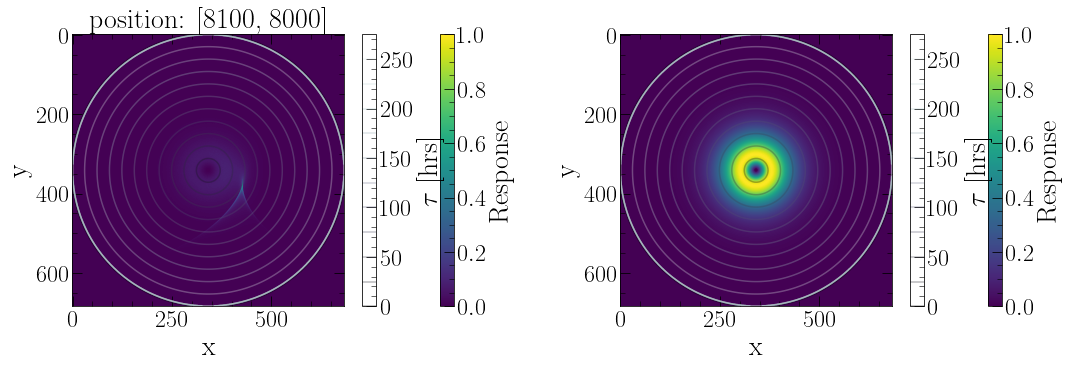

In [19]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
conts1 = ax[0].imshow(magresponse/np.max((magresponse)))
conts2 = ax[1].imshow(sanityresponse/np.max((sanityresponse)))
conts3 = ax[0].contour(magdelays, 10, cmap='bone', alpha=0.3)
conts4 = ax[1].contour(sanitydelays, 10, cmap='bone', alpha=0.3)

ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].set_ylabel("y")
ax[0].set_title("position: ["+str(X1)+', '+str(Y1)+']')

cbar1 = plt.colorbar(conts1, ax=ax[0], label='Response')
cbar2 = plt.colorbar(conts2, ax=ax[1], label='Response')
cbar3 = plt.colorbar(conts3, ax=ax[0], label=r'$\tau$ [hrs]')
cbar4 = plt.colorbar(conts4, ax=ax[1], label=r'$\tau$ [hrs]')
plt.show()   # Imshow has inverted y axis


In [20]:
TF1 = MicrolensedResponse(Map1, ADisk1, 500, 6, x_position=X1, y_position=Y1, smooth=True)
TFSanity = MicrolensedResponse(MagMapSanity, ADisk1, 500, 6, smooth=True)
rawTF1 = MicrolensedResponse(Map1, ADisk1, 500, 6, x_position=X1, y_position=Y1)
rawTFSanity = MicrolensedResponse(MagMapSanity, ADisk1, 500, 6)

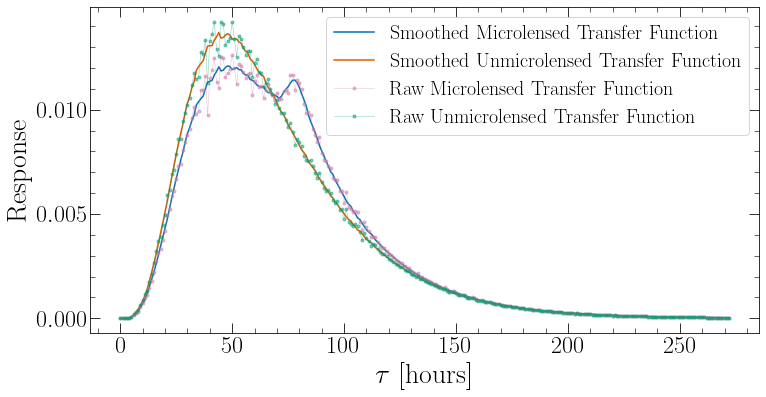

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(TF1, label='Smoothed Microlensed Transfer Function')
ax.plot(TFSanity, label='Smoothed Unmicrolensed Transfer Function')
ax.plot(rawTF1, '.-', label='Raw Microlensed Transfer Function', linewidth=0.5, alpha=0.5)
ax.plot(rawTFSanity, '.-', label="Raw Unmicrolensed Transfer Function", linewidth=0.5, alpha=0.5)
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel("Response")
ax.legend()
plt.show()

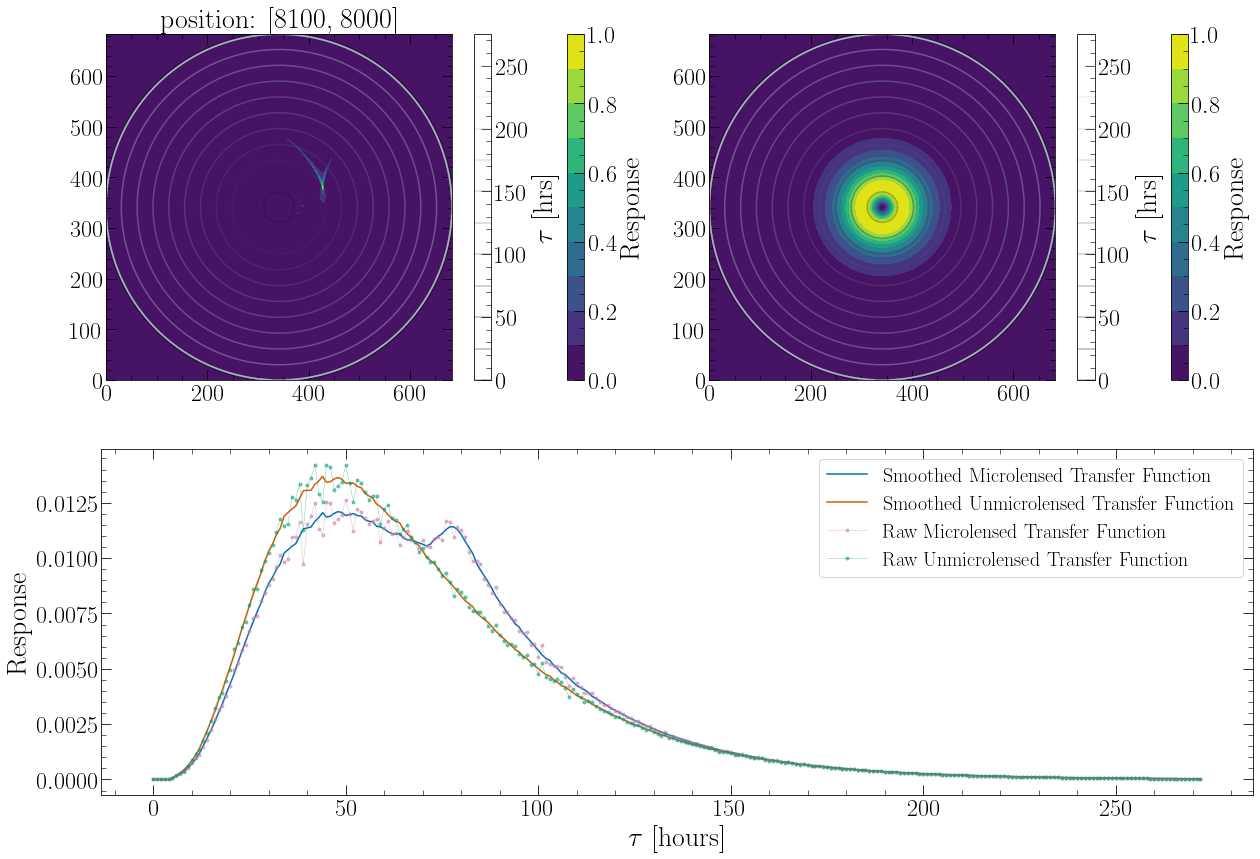

In [22]:
fig, ax = plt.subplots(2,2, figsize=(16,14))
gs = ax[1, 0].get_gridspec()
for axis in ax[1, :]:
    axis.remove()
bigax = fig.add_subplot(gs[1, :])

conts1 = ax[0,0].contourf(magresponse/np.max(magresponse), 10)
conts2 = ax[0,1].contourf(sanityresponse/np.max(sanityresponse), 10)
conts3 = ax[0,0].contour(magdelays, 10, cmap='bone', alpha=0.3)
conts4 = ax[0,1].contour(sanitydelays, 10, cmap='bone', alpha=0.3)

ax[0,0].set_aspect(1)
ax[0,1].set_aspect(1)
ax[0,0].set_title("position: ["+str(X1)+', '+str(Y1)+']')

cbar1 = plt.colorbar(conts1, ax=ax[0,0], label='Response')
cbar2 = plt.colorbar(conts2, ax=ax[0,1], label='Response')
cbar3 = plt.colorbar(conts3, ax=ax[0,0], label=r'$\tau$ [hrs]')
cbar4 = plt.colorbar(conts4, ax=ax[0,1], label=r'$\tau$ [hrs]')

bigax.plot(TF1, label='Smoothed Microlensed Transfer Function')
bigax.plot(TFSanity, label='Smoothed Unmicrolensed Transfer Function')
bigax.plot(rawTF1, '.-', label='Raw Microlensed Transfer Function', linewidth=0.5, alpha=0.5)
bigax.plot(rawTFSanity, '.-', label="Raw Unmicrolensed Transfer Function", linewidth=0.5, alpha=0.5)
bigax.set_xlabel(r"$\tau$ [hours]")
bigax.set_ylabel("Response")
bigax.legend()

fig.subplots_adjust(wspace=0.1, left=0, right=1)
plt.show()
fig.savefig("MicrolensedResponse.pdf")

In [23]:
print(np.shape(TF1))
print(np.max(magdelays))

(273,)
273.5349014671763


In [24]:
timedependTF = np.zeros((10, 273))
for jj in range(10):
    timedependTF[jj, :] = MicrolensedResponse(Map1, ADisk1, 500, 6, x_position=4000, y_position=jj*100+3000, smooth=True)
    

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:522: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*T_orig**3)


In [25]:
pxratio = ADisk1.pxsize/Map1.px_size
DerivDisk1 = ADisk1.MakeDBDTMap(500)
adjusteddisk = rescale(DerivDisk1*ADisk1.MakeDTDLxMap(DerivDisk1, axisoffset=0,
                                                           angleoffset=0), pxratio)
disksize = np.size(adjusteddisk, 0)//2

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in power
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: invalid value encountered in multiply
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


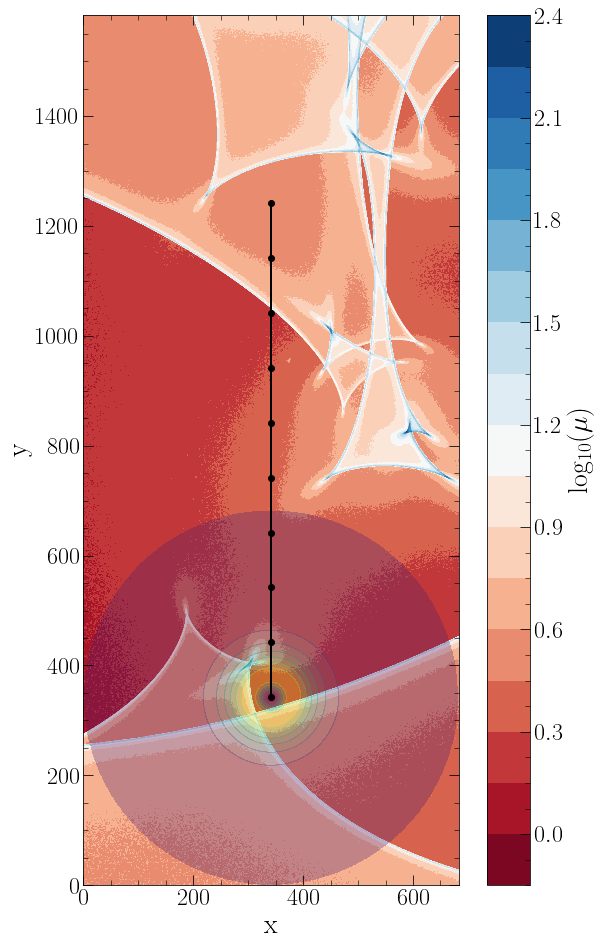

In [26]:
xvals = np.linspace(disksize, disksize, 10)
yvals = np.linspace(disksize, disksize+900, 10)
fig, ax = plt.subplots(figsize=(10, 16))
conts = ax.contourf(np.log10(Map1.mag_map[3000-disksize:3900+disksize, 4000-disksize:4000+disksize]), 20, cmap='RdBu')
disk = ax.contourf(adjusteddisk, alpha=0.3)
ax.plot(xvals, yvals, '.-', linewidth=2, color='black', markersize=12)
ax.set_aspect(1)
cbar = plt.colorbar(conts, label=r'log$_{10}(\mu)$')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

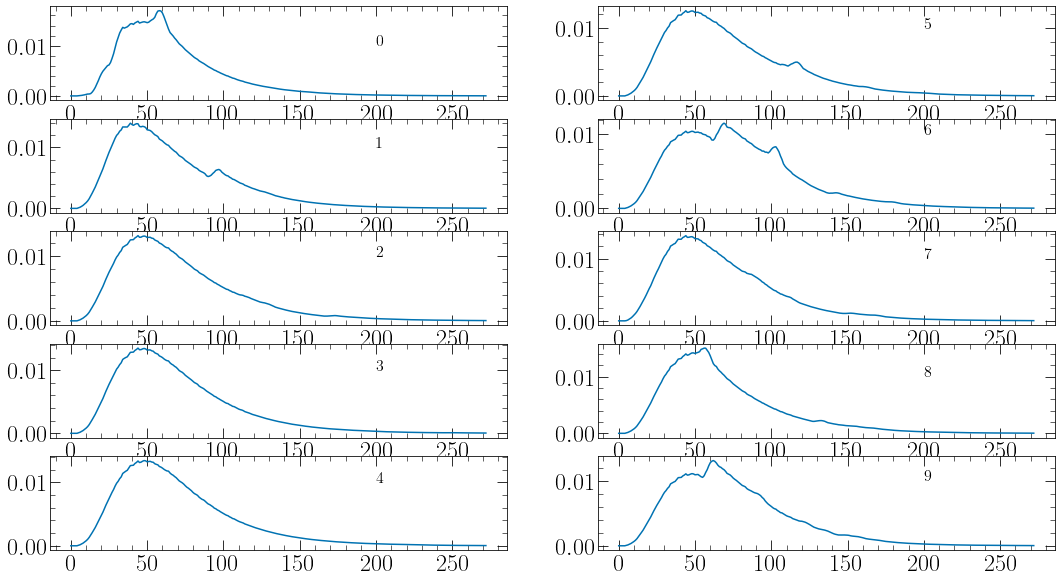

In [27]:
fig, ax = plt.subplots(5, 2, figsize=(18,10))
ax[0,0].plot(timedependTF[0, :])
ax[1,0].plot(timedependTF[1, :])
ax[2,0].plot(timedependTF[2, :])
ax[3,0].plot(timedependTF[3, :])
ax[4,0].plot(timedependTF[4, :])
ax[0,1].plot(timedependTF[5, :])
ax[1,1].plot(timedependTF[6, :])
ax[2,1].plot(timedependTF[7, :])
ax[3,1].plot(timedependTF[8, :])
ax[4,1].plot(timedependTF[9, :])
ax[0,0].text(200, 0.01, "0", fontsize=16)
ax[1,0].text(200, 0.01, "1", fontsize=16)
ax[2,0].text(200, 0.01, "2", fontsize=16)
ax[3,0].text(200, 0.01, "3", fontsize=16)
ax[4,0].text(200, 0.01, "4", fontsize=16)
ax[0,1].text(200, 0.01, "5", fontsize=16)
ax[1,1].text(200, 0.01, "6", fontsize=16)
ax[2,1].text(200, 0.01, "7", fontsize=16)
ax[3,1].text(200, 0.01, "8", fontsize=16)
ax[4,1].text(200, 0.01, "9", fontsize=16)
plt.show()

In [28]:
delays2, MLTF2, XVals2, YVals2 = Map1.GenerateMicrolensedResponse(ADisk1, 500, x_position=x_val1, y_position=y_val1, returnmaps=True)

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:522: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*T_orig**3)


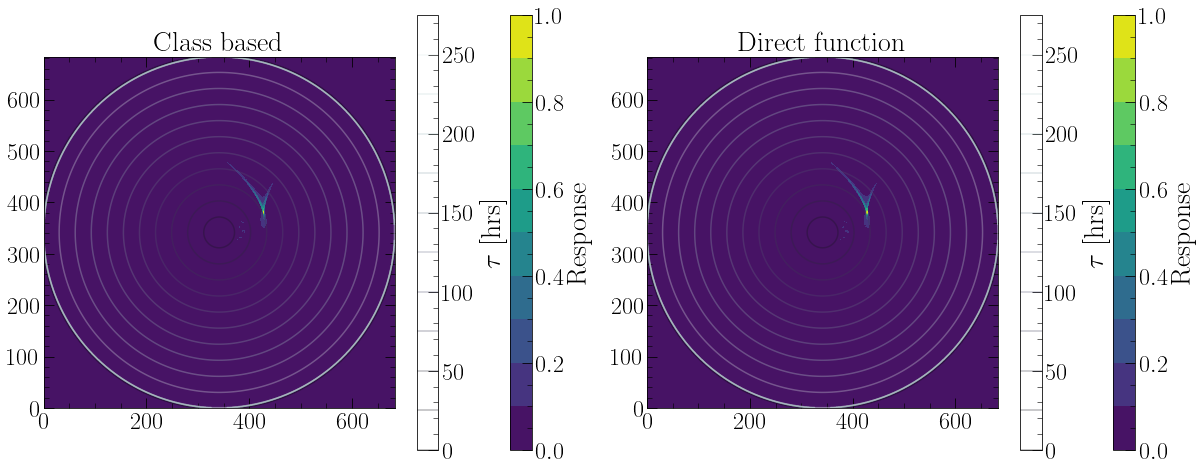

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

conts1 = ax[0].contourf(MLTF2/np.max(MLTF2), 10)
conts2 = ax[1].contourf(magresponse/np.max(magresponse), 10)
conts3 = ax[0].contour(delays2, 10, cmap='bone', alpha=0.3)
conts4 = ax[1].contour(magdelays, 10, cmap='bone', alpha=0.3)
ax[0].set_title("Class based")
ax[1].set_title("Direct function")

ax[0].set_aspect(1)
ax[1].set_aspect(1)

cbar1 = plt.colorbar(conts1, ax=ax[0], label='Response')
cbar2 = plt.colorbar(conts2, ax=ax[1], label='Response')
cbar3 = plt.colorbar(conts3, ax=ax[0], label=r'$\tau$ [hrs]')
cbar4 = plt.colorbar(conts4, ax=ax[1], label=r'$\tau$ [hrs]')

fig.subplots_adjust(wspace=0.1, left=0, right=1)
plt.show()